## Cost Update

Test methods for updating the global costmap from local observations

In [1]:
import numpy as np
import os
from matplotlib import image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import cv2 as cv
# import GPy
from scipy.interpolate import RBFInterpolator

from nerfnav.global_planner import GlobalPlanner
from nerfnav.utils import rgb2gray, pc_plot_trace
from nerfnav.feature_map import FeatureMap, CostMap
from nerfnav.autonav import AutoNav

%load_ext autoreload
%autoreload 2

### Parameters and Setup

In [2]:
UNREAL_PLAYER_START = np.array([-117252.054688, 264463.03125, 25148.908203])
UNREAL_GOAL = np.array([-83250.0, 258070.0, 24860.0])

GOAL_POS = (UNREAL_GOAL - UNREAL_PLAYER_START)[:2] / 100.0

global_img = cv.imread('../data/airsim/images/test_scenario.png')
global_img = global_img[::2, ::2, :]
start_px = (138, 141)
goal_px = (78, 493)

### Global costmap and planner

In [6]:
costmap_data = np.load('../data/airsim/costmap.npz')
costmap = CostMap(costmap_data['mat'], costmap_data['cluster_labels'], costmap_data['cluster_masks'])

feat_map = FeatureMap(global_img, start_px, goal_px, UNREAL_PLAYER_START, UNREAL_GOAL)
global_planner = GlobalPlanner(costmap, feat_map, goal_px)

#init_path = global_planner.replan(np.zeros(3))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(global_img)
im = global_planner.plot(ax[1])
# plt.colorbar(im, ax=ax[1])
plt.show()

### Local observation

  MAX LOCAL COST:  66.78827717735304


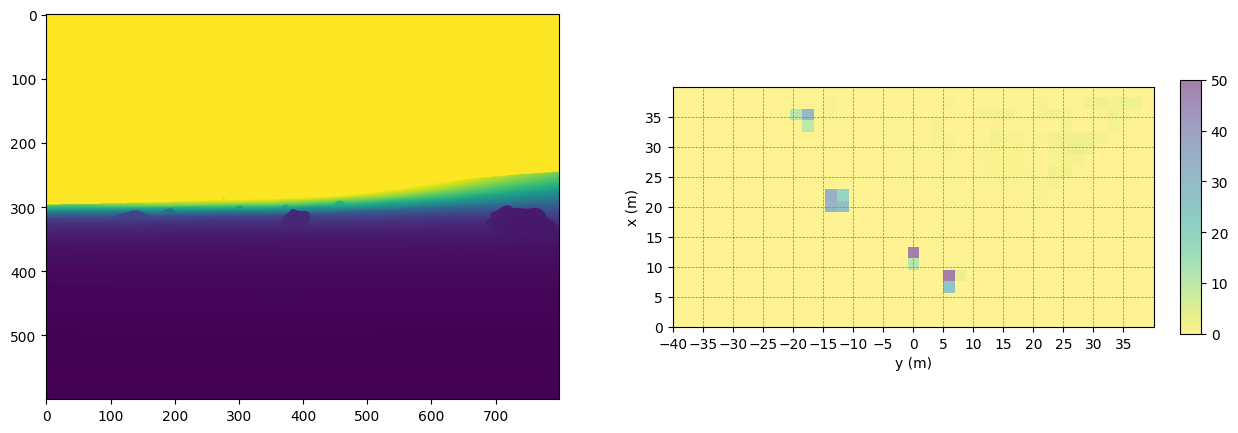

In [4]:
depth = np.load('../data/airsim/images/rover/depth_rocks.npy')
pose = np.array([169.813, -23.864, -0.104])  # x, y, yaw

depth_vis = depth.copy()
depth_vis[depth_vis > 100] = 100.0

autonav = AutoNav(np.zeros(2))
cost_vals = autonav.update_costmap(pose, depth)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(depth_vis)
im = autonav.plot_costmap(ax[1])
plt.colorbar(im, fraction=0.04, aspect=12)

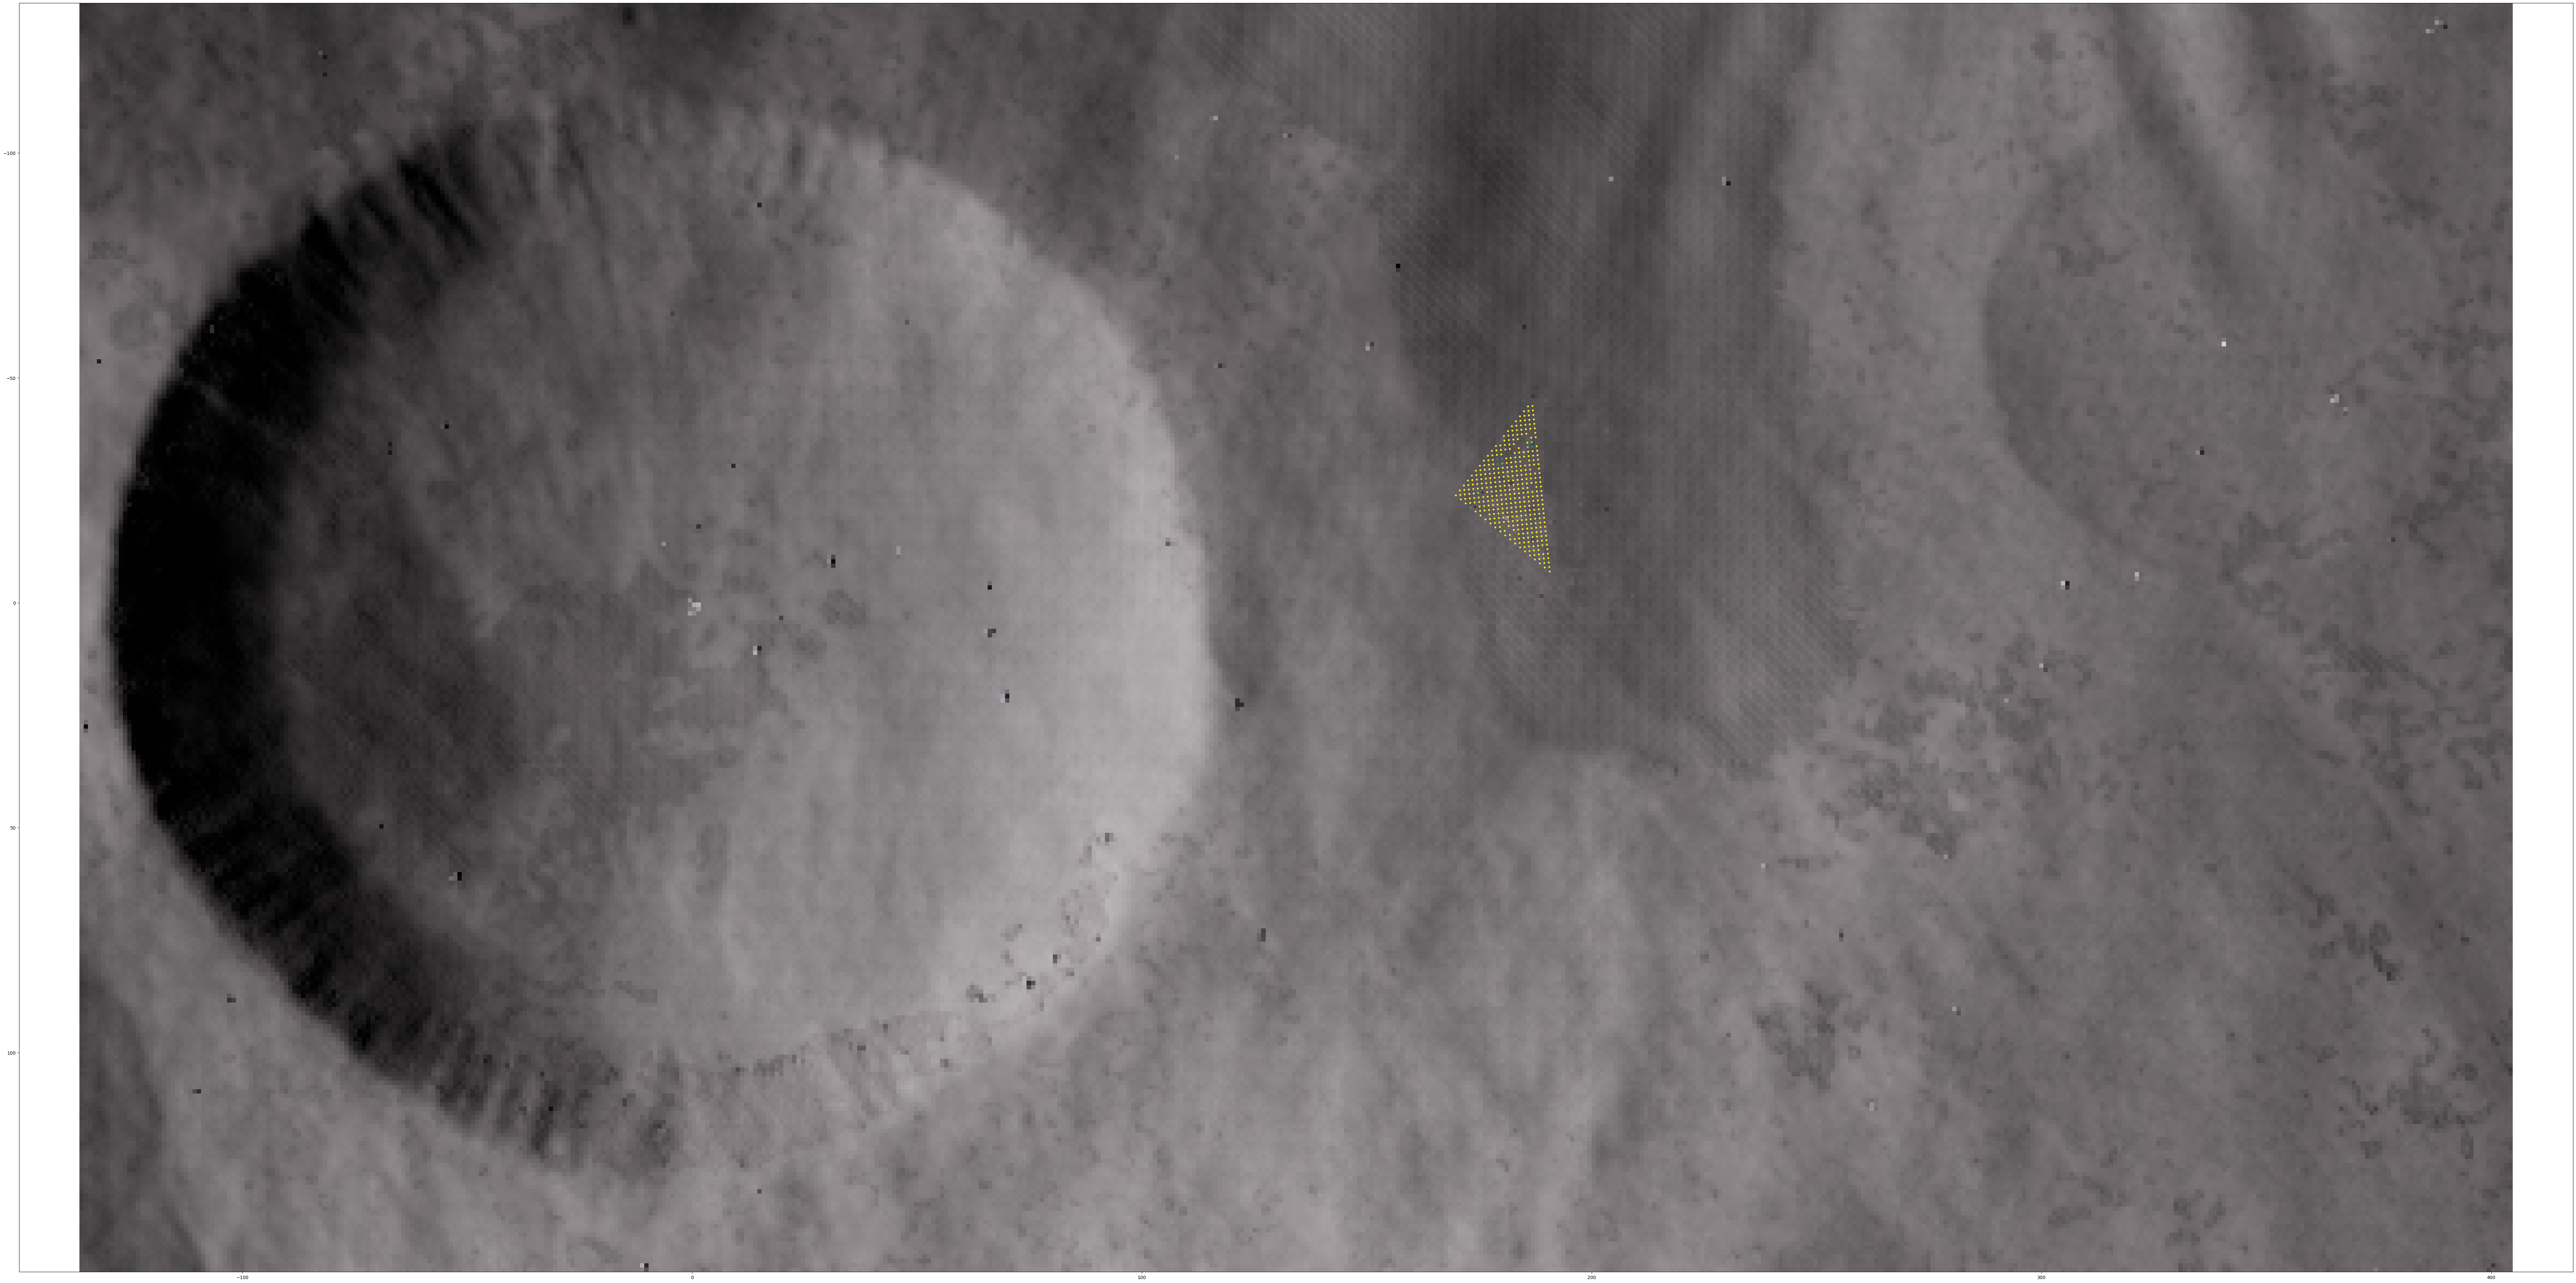

In [7]:
cvs = np.array(cost_vals)
fig, ax = plt.subplots(1, 1, figsize=(100, 50))
s = ax.scatter(cvs[:, 0], cvs[:, 1], c=cvs[:, 2], cmap='viridis_r', s=10)
xmin, xmax, ymin, ymax = feat_map.bounds
ax.imshow(global_img, extent=[xmin, xmax, ymax, ymin])
#ax.invert_yaxis()
plt.axis('equal')
plt.show()

In [8]:
# Plot cvs in 3D with plotly
data = pc_plot_trace(cvs, color='blue')
fig = go.Figure(data=data)
fig.show()

### Cost interpolation

In [15]:
from sklearn.neighbors import KernelDensity

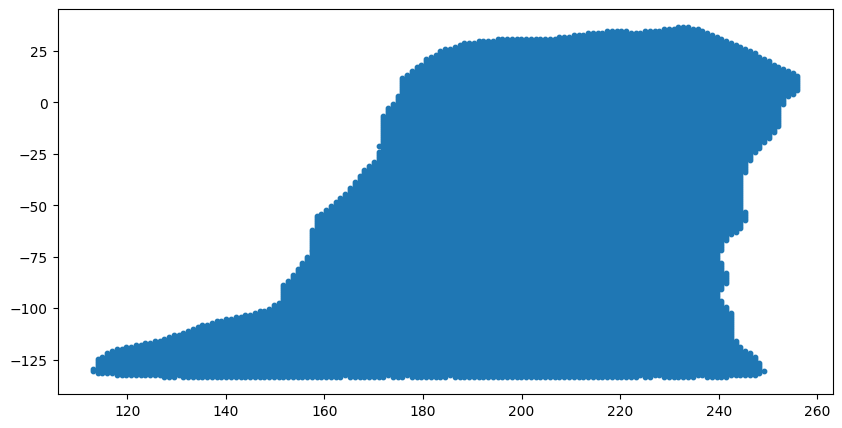

In [9]:
X, Y = feat_map.img_to_global(costmap.cluster_pts[2][:,0], costmap.cluster_pts[2][:,1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X, Y, s=10)

(105.8700339149091, 263.1295368469091, -141.80402352836367, 45.20727725563637)

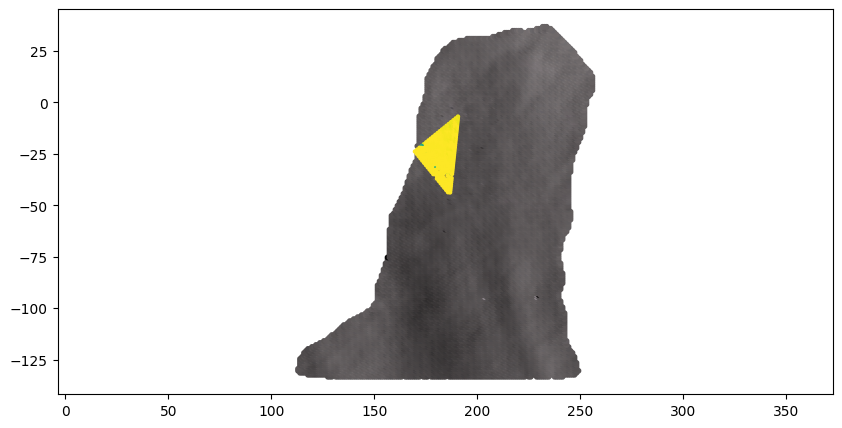

In [48]:
coords = costmap.cluster_pts[2]
RGB = global_img[coords[:,0], coords[:,1], :]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X, Y, s=10, c=RGB/255.0)
ax.scatter(cvs[:, 0], cvs[:, 1], c=cvs[:, 2], cmap='viridis_r', s=5)
plt.axis('equal')

(168.76951097815217,
 191.7262694588043,
 -45.579187778712075,
 -5.0990950617098045)

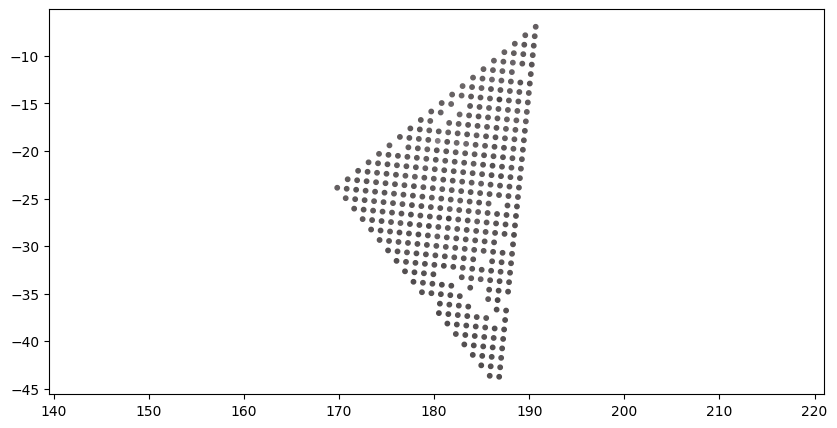

In [56]:
sample_RGB = feat_map.get_features(cvs[:, [1,0]])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(cvs[:, 0], cvs[:, 1], c=sample_RGB/255.0, s=10)
plt.axis('equal')

In [79]:
norm_const = max(np.abs([min(X), max(X), min(Y), max(Y)]))

In [80]:
features = np.hstack((X[:,None]/norm_const, Y[:,None]/norm_const, RGB/255.0))
features

array([[ 0.49811321, -0.52075472,  0.30980392,  0.29803922,  0.30196078],
       [ 0.50188679, -0.52075472,  0.34509804,  0.3254902 ,  0.32941176],
       [ 0.50566038, -0.52075472,  0.3254902 ,  0.31372549,  0.31764706],
       ...,
       [ 0.90566038,  0.14339623,  0.41568627,  0.4       ,  0.40392157],
       [ 0.90943396,  0.14339623,  0.40784314,  0.38823529,  0.39215686],
       [ 0.91320755,  0.14339623,  0.40392157,  0.38431373,  0.38823529]])

In [81]:
sample_features = np.hstack((cvs[:, :2]/norm_const, sample_RGB/255.0))

In [101]:
kde = KernelDensity(kernel='linear', bandwidth=0.5).fit(sample_features, cvs[:, 2])
density = np.exp(kde.score_samples(features))

(105.8700339149091, 263.1295368469091, -141.80402352836367, 45.20727725563637)

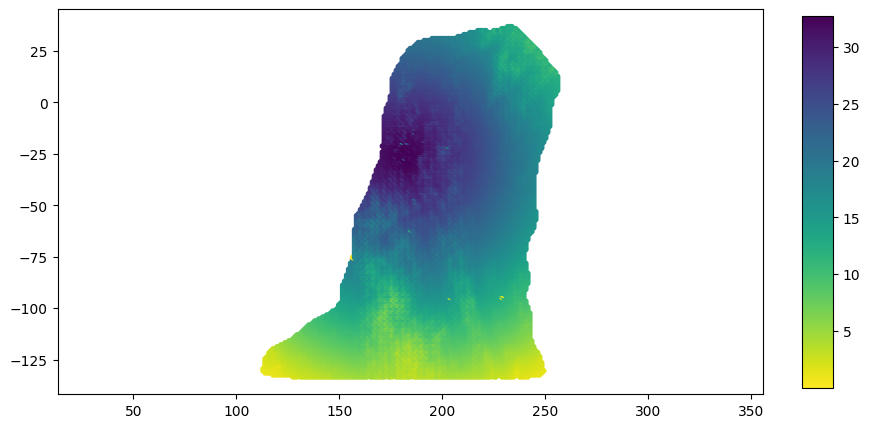

In [102]:
coords = costmap.cluster_pts[2]
RGB = global_img[coords[:,0], coords[:,1], :]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.scatter(X, Y, s=10, c=density, cmap='viridis_r')
plt.colorbar(im, fraction=0.04, aspect=12)
#ax.scatter(cvs[:, 0], cvs[:, 1], c=cvs[:, 2], cmap='viridis_r', s=5)
plt.axis('equal')

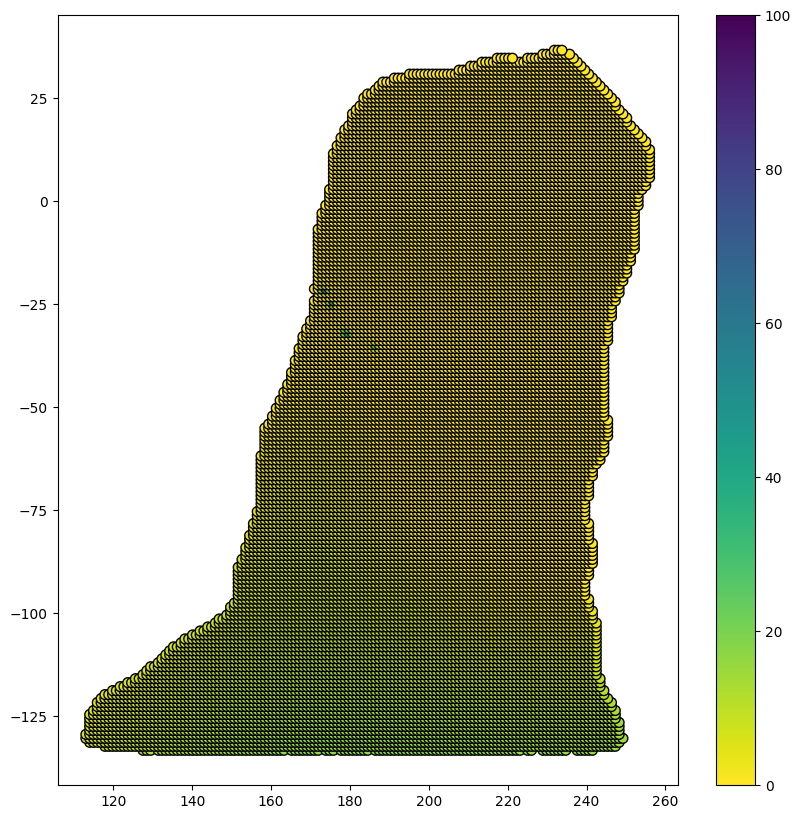

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
p = ax.scatter(*xflat.T, c=interp_vals, s=50, ec='k', vmin=0, vmax=100, cmap='viridis_r')
fig.colorbar(p)
plt.show()

In [14]:
buff = 20
xgrid = np.mgrid[min(cvs[:,0])-buff:max(cvs[:,0])+buff:50j, min(cvs[:,1])-buff:max(cvs[:,1])+buff:50j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(cvs[:, :2], cvs[:, 2])(np.stack((X, Y), axis=1))
ygrid = yflat.reshape(xgrid.shape[1:])

ValueError: cannot reshape array of size 15753 into shape (50,50)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolormesh(*xgrid, ygrid, vmin=0, vmax=100, shading='gouraud', cmap='viridis_r')
p = ax.scatter(*cvs[:,:2].T, c=cvs[:,2], s=50, ec='k', vmin=0, vmax=100, cmap='viridis_r')
fig.colorbar(p)
plt.show()

In [ ]:
from scipy.stats.qmc import Halton

rng = np.random.default_rng()
xobs = 2*Halton(2, seed=rng).random(1000) - 1
yobs = np.sum(xobs, axis=1)*np.exp(-6*np.sum(xobs**2, axis=1))

In [ ]:
xgrid = np.mgrid[-1:1:50j, -1:1:50j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(xobs, yobs)(xflat)
ygrid = yflat.reshape(50, 50)

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(*xgrid, ygrid, vmin=-0.25, vmax=0.25, shading='gouraud')
p = ax.scatter(*xobs.T, c=yobs, s=50, ec='k', vmin=-0.25, vmax=0.25)
fig.colorbar(p)
plt.show()

### By cluster

In [ ]:
global_planner.update_costmap(cost_vals)

In [ ]:
# Plot local samples on top of global map
fig, ax = plt.subplots(figsize=(10, 5))
im = global_planner.plot(ax)
#s = ax.scatter(cvs[:, 0], cvs[:, 1], c=cvs[:, 2], ec='k', cmap='viridis_r', s=10)
plt.colorbar(im, fraction=0.04, aspect=12)
plt.axis('equal')
plt.show()

In [ ]:
costmap.mat.shape

In [ ]:
292 * 560

In [ ]:
global_planner.update_costmap(cost_vals)

In [ ]:
local_samples = costmap.num_clusters * [None]

for x, y, c in cost_vals:
    i, j = feat_map.global_to_img(x, y)
    k = int(costmap.clusters[i, j])
    if local_samples[k] is None:
        local_samples[k] = []
    local_samples[k].append((x, y, c))

In [ ]:
local_samples[4]